In [ ]:
# Created on: 26.01.2026, 16:51
# In this script ======
#   I will load the firing rates for each CF, which gives me the AN output.
#   Then I will apply power function, - imitates the sharpening of tuning curves
# after AN stages, in subcortical.
# I want to find the n that gives me an optimum sharpening profile.
# It might be interesting to compare this with a lateral inhibition operation
# Idk though.
# Checking different papers to identify the steps they apply after AN simulation
# can be a good idea.
# Created by: Ekim Celikay

# 1. Apply power function
# 2. Re-normalize (divide by pooled activity)

# ==== POWER-LAW NONLINEARITY ====
#   - Applying a power function sharpens tuning curves by:
#       - Suppressing weak responses more than strong responses.
#       - Enhancing the peak relative to flanks.
#       - It's a pointwise nonlinearity, meaning that each channel is
#           processed independently.
# Power-law (n>1) enhances contrast by expanding the dynamic range.
# r_powered = r^n, where n>1
# Then you need to re-normalize:
#
# or sometimes:
# r_normalized = r_powered / (σ + (Σ_j w_ij * r_j^n)^(1/n))
# Power function: Enhances strong responses, suppresses weak ones
# Apply divisive normalization if you want to model lateral inhibition (28.01)
# Divisive Normalization: Divides by the pooled activity of neighbors, creating gain control
# Net effect: Strong lateral inhibition - responses are suppressed based on overall population activity
# 28/01/26:
# - adding the power functions.
# - the plotting notebook: 'powerlaw_visualization.ipynb'
# - loaders moved to its own script in utils 'cochlea_loader_functions.py'.




# imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import logging
from pathlib import Path
import pandas as pd

# Project imports
from utils.cochlea_loader_functions import load_cochlea_results, organize_for_eachtone_allCFs


# ================= Function drafts ====================



def apply_power_function(response_matrix, exponent):
    return np.power(response_matrix, exponent)

def apply_multiple_power_functions(response_matrix, exponents):
    results = {'original': response_matrix.copy()}
    for exp in exponents:
        results[exp] = apply_power_function(response_matrix, exp)
    return results

def apply_power_with_percf_normalization(response_matrix, exponent):
    r_powered= apply_power_function(response_matrix, exponent)
    # Normalize each CF (each row) to its own max
    max_per_cf = np.max(r_powered, axis=1, keepdims=True)
    r_normalized = r_powered / (max_per_cf + 1e-10)
    return r_normalized

def apply_multiple_power_with_percf_normalization(response_matrix, exponents):
    results = {'original': response_matrix.copy()}
    results['original'] = apply_power_with_percf_normalization(results['original'], 1.0)
    for exp in exponents:
        results[exp] = apply_power_with_percf_normalization(response_matrix, exp)
    return results

def plot_single_cf_single_exponent(response_matrix, tone_freqs, cf_list, cf_idx, exponent, figsize=(10, 6)):
    """Plot tuning curve for a single CF with a single power exponent.

    Args:
        response_matrix: Original response matrix (num_cf, num_tones)
        tone_freqs: Array of tone frequencies
        cf_list: Array of CF values
        cf_idx: Index of CF to plot
        exponent: Power exponent to apply
        figsize: Figure size tuple

    Returns:
        fig, ax: Matplotlib figure and axis objects
    """
    transformed_response = apply_power_with_percf_normalization(response_matrix, exponent)

    fig, ax = plt.subplots(figsize=figsize)
    tuning_curve = transformed_response[cf_idx, :]
    ax.plot(tone_freqs, tuning_curve, label=f'exp={exponent}')
    ax.set_xscale('log')
    ax.set_xlabel('Tone Frequency (Hz)')
    ax.set_ylabel('Firing Rate (spikes/s)')
    ax.set_title(f'Tuning Curve for CF={cf_list[cf_idx]:.0f} Hz')
    ax.legend()
    ax.grid(True, alpha=0.3)

    return fig, ax


def plot_single_cf_multiple_exponents(response_matrix, tone_freqs, cf_list, cf_idx, exponents, figsize=(10, 6), verbose=True):
    """Plot tuning curves for a single CF with multiple power exponents.

    Args:
        response_matrix: Original response matrix (num_cf, num_tones)
        tone_freqs: Array of tone frequencies
        cf_list: Array of CF values
        cf_idx: Index of CF to plot
        exponents: List of power exponents to apply
        figsize: Figure size tuple
        verbose: Print debug information

    Returns:
        fig, ax: Matplotlib figure and axis objects
    """
    transformed_responses = apply_multiple_power_with_percf_normalization(response_matrix, exponents)

    fig, ax = plt.subplots(figsize=figsize)

    # Plot each curve and print info
    for key in transformed_responses.keys():
        curve = transformed_responses[key][cf_idx, :]
        if verbose:
            print(f"{key}: shape={curve.shape}, max={curve.max():.2f}")

        if key == 'original':
            ax.plot(tone_freqs, curve, 'k--', linewidth=2.5, label=key, alpha=0.7)
        else:
            ax.plot(tone_freqs, curve, linewidth=2, label=f'exp={key}')

    ax.set_xscale('log')
    ax.set_xlabel('Tone Frequency (Hz)')
    ax.set_ylabel('Firing Rate (spikes/s)')
    ax.set_title(f'CF = {cf_list[cf_idx]:.0f} Hz')
    ax.legend()
    ax.grid(True, alpha=0.3)

    return fig, ax


def plot_all_cfs_multiple_exponents(response_matrix, tone_freqs, cf_list, exponents, n_cols=5, verbose=True):
    """Plot tuning curves for all CFs with multiple power exponents in a grid.

    Args:
        response_matrix: Original response matrix (num_cf, num_tones)
        tone_freqs: Array of tone frequencies
        cf_list: Array of CF values
        exponents: List of power exponents to apply
        n_cols: Number of columns in subplot grid
        verbose: Print debug information

    Returns:
        fig, axes: Matplotlib figure and axes array
    """
    # TODO: Need to add a proper title
    # TODO: AXES labels are not present in this figure.
    # TODO: Top CFs are not visible because of the legend
    # TODO: Where to add the normalization information?
    transformed_responses = apply_multiple_power_with_percf_normalization(response_matrix, exponents)

    num_cf = len(cf_list)
    n_rows = int(np.ceil(num_cf / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = axes.flatten()

    # Define colors once for exponents
    exp_list = [k for k in transformed_responses.keys() if k != 'original']
    exp_list = sorted(exp_list)

    if verbose:
        print(f"Plotting exponents: {exp_list}")

    colors = plt.cm.viridis(np.linspace(0, 1, len(exp_list)))

    # Loop through CFs
    for cf_idx in range(num_cf):
        ax = axes[cf_idx]

        # Plot original tuning curve in black
        tuning_curve = transformed_responses['original'][cf_idx, :]
        ax.plot(tone_freqs, tuning_curve, 'k--', linewidth=2, alpha=0.5, label='original')

        # Plot each exponent with color
        for idx, exp in enumerate(exp_list):
            tuning_curve = transformed_responses[exp][cf_idx, :]
            ax.plot(tone_freqs, tuning_curve, color=colors[idx], linewidth=1.5, label=f'{exp}')

        ax.set_xscale('log')
        ax.set_title(f'CF={cf_list[cf_idx]:.0f} Hz', fontsize=8)
        ax.tick_params(labelsize=6)
        ax.grid(True, alpha=0.2)

    # Add one legend to the figure
    fig.legend(['original'] + [f'exp={exp}' for exp in exp_list],
               loc='upper center', ncol=len(exp_list)+1, fontsize=10)

    plt.tight_layout()

    return fig, axes





# ============= KEY CONCEPTS =============

# 1. Basic loop structure:
#    for data in your_data:
#        ax.plot(x, y, label=something)

# 2. Extracting data:
#    - For one CF: matrix[cf_idx, :] gives you (num_tones,)
#    - For one tone: matrix[:, tone_idx] gives you (num_cf,)

# 3. Styling:
#    - Use lists of colors/styles and index with enumerate
#    - Or use colormaps: plt.cm.viridis(np.linspace(0, 1, n))

# 4. Legend:
#    - Add label= parameter to each plot() call
#    - Call ax.legend() once at the end

# 5. Multiple subplots:
#    - fig, axes = plt.subplots(rows, cols)
#    - Loop through axes and plot different data on each

def calculate_Q10(frequencies, firing_rates, CF):
    # TODO: WORK ON CALCULATING Q10 FACTOR.


    # Find peak response
    peak_response = np.max(firing_rates)

    # Find resonse 10 dB below peak (= peak / sqrt(10) approximates peak / 3.16)
    threshold_10dB = peak_response / np.sqrt(10)

    # Find frequencies where response crosses this threshold
    above_threshold = firing_rates >= threshold_10dB
    freqs_above = frequencies[above_threshold]

    if len(freqs_above) < 2:
        return np.nan

    # Bandwidth = max freq - min freq at this level
    bandwith = freqs_above[-1] - freqs_above[0]

    # Q = CF / bandwidth
    Q10 = CF / bandwith
    return Q10

# Step 1: Calculate baseline q10db from original AN responses


def calculate_Q10dB(frequencies, firing_rates, cf):
    """
    Calculate Q10dB from neural tuning curve (firing rates vs frequency).

    Parameters:
    -----------
    frequencies : array
        Tone frequencies tested (Hz)
    firing_rates : array
        Firing rates at each frequency (spikes/s)
    cf : float
        Characteristic frequency of this neuron (Hz)

    Returns:
    --------
    q10db : float
        Q factor at -10dB bandwidth
    bw_10db : float
        Bandwidth in Hz
    f_low : float
        Lower cutoff frequency
    f_high : float
        Upper cutoff frequency
    """
    # Find peak response
    peak_response = np.max(firing_rates)

    if peak_response == 0:
        return np.nan, np.nan, np.nan, np.nan

    # -10dB means response drops to 1/√10 ≈ 0.316 of peak (in amplitude)
    threshold_10dB = peak_response / np.sqrt(10)

    # Find frequencies where response is above threshold
    above_threshold = firing_rates >= threshold_10dB

    if np.sum(above_threshold) < 2:
        return np.nan, np.nan, np.nan, np.nan

    # Get frequency range at -10dB
    indices = np.where(above_threshold)[0]
    f_low = frequencies[indices[0]]
    f_high = frequencies[indices[-1]]

    # Calculate bandwidth and Q
    bw_10db = f_high - f_low

    if bw_10db == 0:
        return np.nan, np.nan, f_low, f_high

    q10db = cf / bw_10db

    return q10db, bw_10db, f_low, f_high


def calculate_Q_at_level(frequencies, firing_rates, cf, db_level=-10):
    """
    Calculate Q at any dB level below peak.

    Parameters:
    -----------
    frequencies : array
        Tone frequencies tested (Hz)
    firing_rates : array
        Firing rates at each frequency (spikes/s)
    cf : float
        Characteristic frequency of this neuron (Hz)
    db_level : float
        dB level below peak (e.g., -3, -10, -20, -30)

    Returns:
    --------
    q : float
        Q factor at specified dB level
    bw : float
        Bandwidth in Hz
    f_low : float
        Lower cutoff frequency
    f_high : float
        Upper cutoff frequency
    """
    peak_response = np.max(firing_rates)

    if peak_response == 0:
        return np.nan, np.nan, np.nan, np.nan

    # Convert dB to linear amplitude ratio
    # -XdB means amplitude = peak / 10^(X/20)
    threshold = peak_response / (10 ** (-db_level / 20))

    above_threshold = firing_rates >= threshold

    if np.sum(above_threshold) < 2:
        return np.nan, np.nan, np.nan, np.nan

    indices = np.where(above_threshold)[0]
    f_low = frequencies[indices[0]]
    f_high = frequencies[indices[-1]]

    bw = f_high - f_low

    if bw == 0:
        return np.nan, np.nan, f_low, f_high

    q = cf / bw

    return q, bw, f_low, f_high


def calculate_q_for_all_cfs(response_matrix, tone_freqs, cf_list, db_level=-10):
    """
    Calculate Q metrics for all CFs in response matrix.

    Parameters:
    -----------
    response_matrix : array (num_cf, num_tones)
        Firing rates for each CF at each tone frequency
    tone_freqs : array
        Tone frequencies tested (Hz)
    cf_list : array
        Characteristic frequencies (Hz)
    db_level : float
        dB level below peak (default -10)

    Returns:
    --------
    results : dict
        Dictionary with arrays: 'q', 'bandwidth', 'f_low', 'f_high', 'cf'
    """
    num_cf = len(cf_list)

    q_values = np.zeros(num_cf)
    bw_values = np.zeros(num_cf)
    f_low_values = np.zeros(num_cf)
    f_high_values = np.zeros(num_cf)

    for cf_idx in range(num_cf):
        cf = cf_list[cf_idx]
        firing_rates = response_matrix[cf_idx, :]

        q, bw, f_low, f_high = calculate_Q_at_level(
            tone_freqs, firing_rates, cf, db_level=db_level
        )

        q_values[cf_idx] = q
        bw_values[cf_idx] = bw
        f_low_values[cf_idx] = f_low
        f_high_values[cf_idx] = f_high

    return {
        'q': q_values,
        'bandwidth': bw_values,
        'f_low': f_low_values,
        'f_high': f_high_values,
        'cf': cf_list
    }


def calculate_q_for_multiple_exponents(response_matrix, tone_freqs, cf_list,
                                       exponents, power_func, db_level=-10):
    """
    Calculate Q metrics after applying different power function exponents.

    Parameters:
    -----------
    response_matrix : array (num_cf, num_tones)
        Original firing rates
    tone_freqs : array
        Tone frequencies tested (Hz)
    cf_list : array
        Characteristic frequencies (Hz)
    exponents : list
        List of exponents to test (e.g., [1.5, 2.0, 2.5, 3.0])
    power_func : callable
        Function that applies power transformation
        Should accept (response_matrix, exponent) and return transformed matrix
    db_level : float
        dB level below peak (default -10)

    Returns:
    --------
    results_dict : dict
        Keys are exponents (with 'original'), values are result dicts from calculate_q_for_all_cfs
    """
    results_dict = {}

    # Calculate for original (no transformation)
    results_dict['original'] = calculate_q_for_all_cfs(
        response_matrix, tone_freqs, cf_list, db_level=db_level
    )

    # Calculate for each exponent
    for exp in exponents:
        transformed = power_func(response_matrix, exp)
        results_dict[exp] = calculate_q_for_all_cfs(
            transformed, tone_freqs, cf_list, db_level=db_level
        )

    return results_dict


def summarize_q_results(results_dict):
    """
    Create summary statistics for Q results across conditions.

    Parameters:
    -----------
    results_dict : dict
        Output from calculate_q_for_multiple_exponents

    Returns:
    --------
    summary_df : pandas.DataFrame
        Summary statistics (mean, median, std, min, max) for each condition
    """
    summary_data = []

    for condition, results in results_dict.items():
        q_values = results['q']
        # Remove NaN values
        q_valid = q_values[~np.isnan(q_values)]

        if len(q_valid) > 0:
            summary_data.append({
                'condition': condition,
                'mean_q': np.mean(q_valid),
                'median_q': np.median(q_valid),
                'std_q': np.std(q_valid),
                'min_q': np.min(q_valid),
                'max_q': np.max(q_valid),
                'n_valid': len(q_valid),
                'n_total': len(q_values)
            })

    return pd.DataFrame(summary_data)


def save_q_results(results_dict, output_dir, prefix='q_metrics'):
    """
    Save Q calculation results to files.

    Parameters:
    -----------
    results_dict : dict
        Output from calculate_q_for_multiple_exponents
    output_dir : str or Path
        Directory to save results
    prefix : str
        Prefix for output filenames
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Save detailed results for each condition
    for condition, results in results_dict.items():
        df = pd.DataFrame(results)
        filename = f"{prefix}_exponent_{condition}.csv"
        df.to_csv(output_dir / filename, index=False)

    # Save summary
    summary_df = summarize_q_results(results_dict)
    summary_df.to_csv(output_dir / f"{prefix}_summary.csv", index=False)

In [ ]:
# ============= USAGE =============

sys.path.insert(0, str(Path.cwd().parent))

input_dir =  Path(__file__).parent / "models_output" / "cochlea_test015_approximate"
# Load your data
results, population_results, cf_list = load_cochlea_results(input_dir)
response_matrix, tone_freqs = organize_for_eachtone_allCFs(population_results, cf_list, target_db=60)




Found 40 .npz files
Loaded 40 frequencies
Organized matrix shape: (40, 40)
  - 40 CF channels
  - 40 tone frequencies
  - dB level: 60


In [ ]:
exponents = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

Plotting exponents: [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]


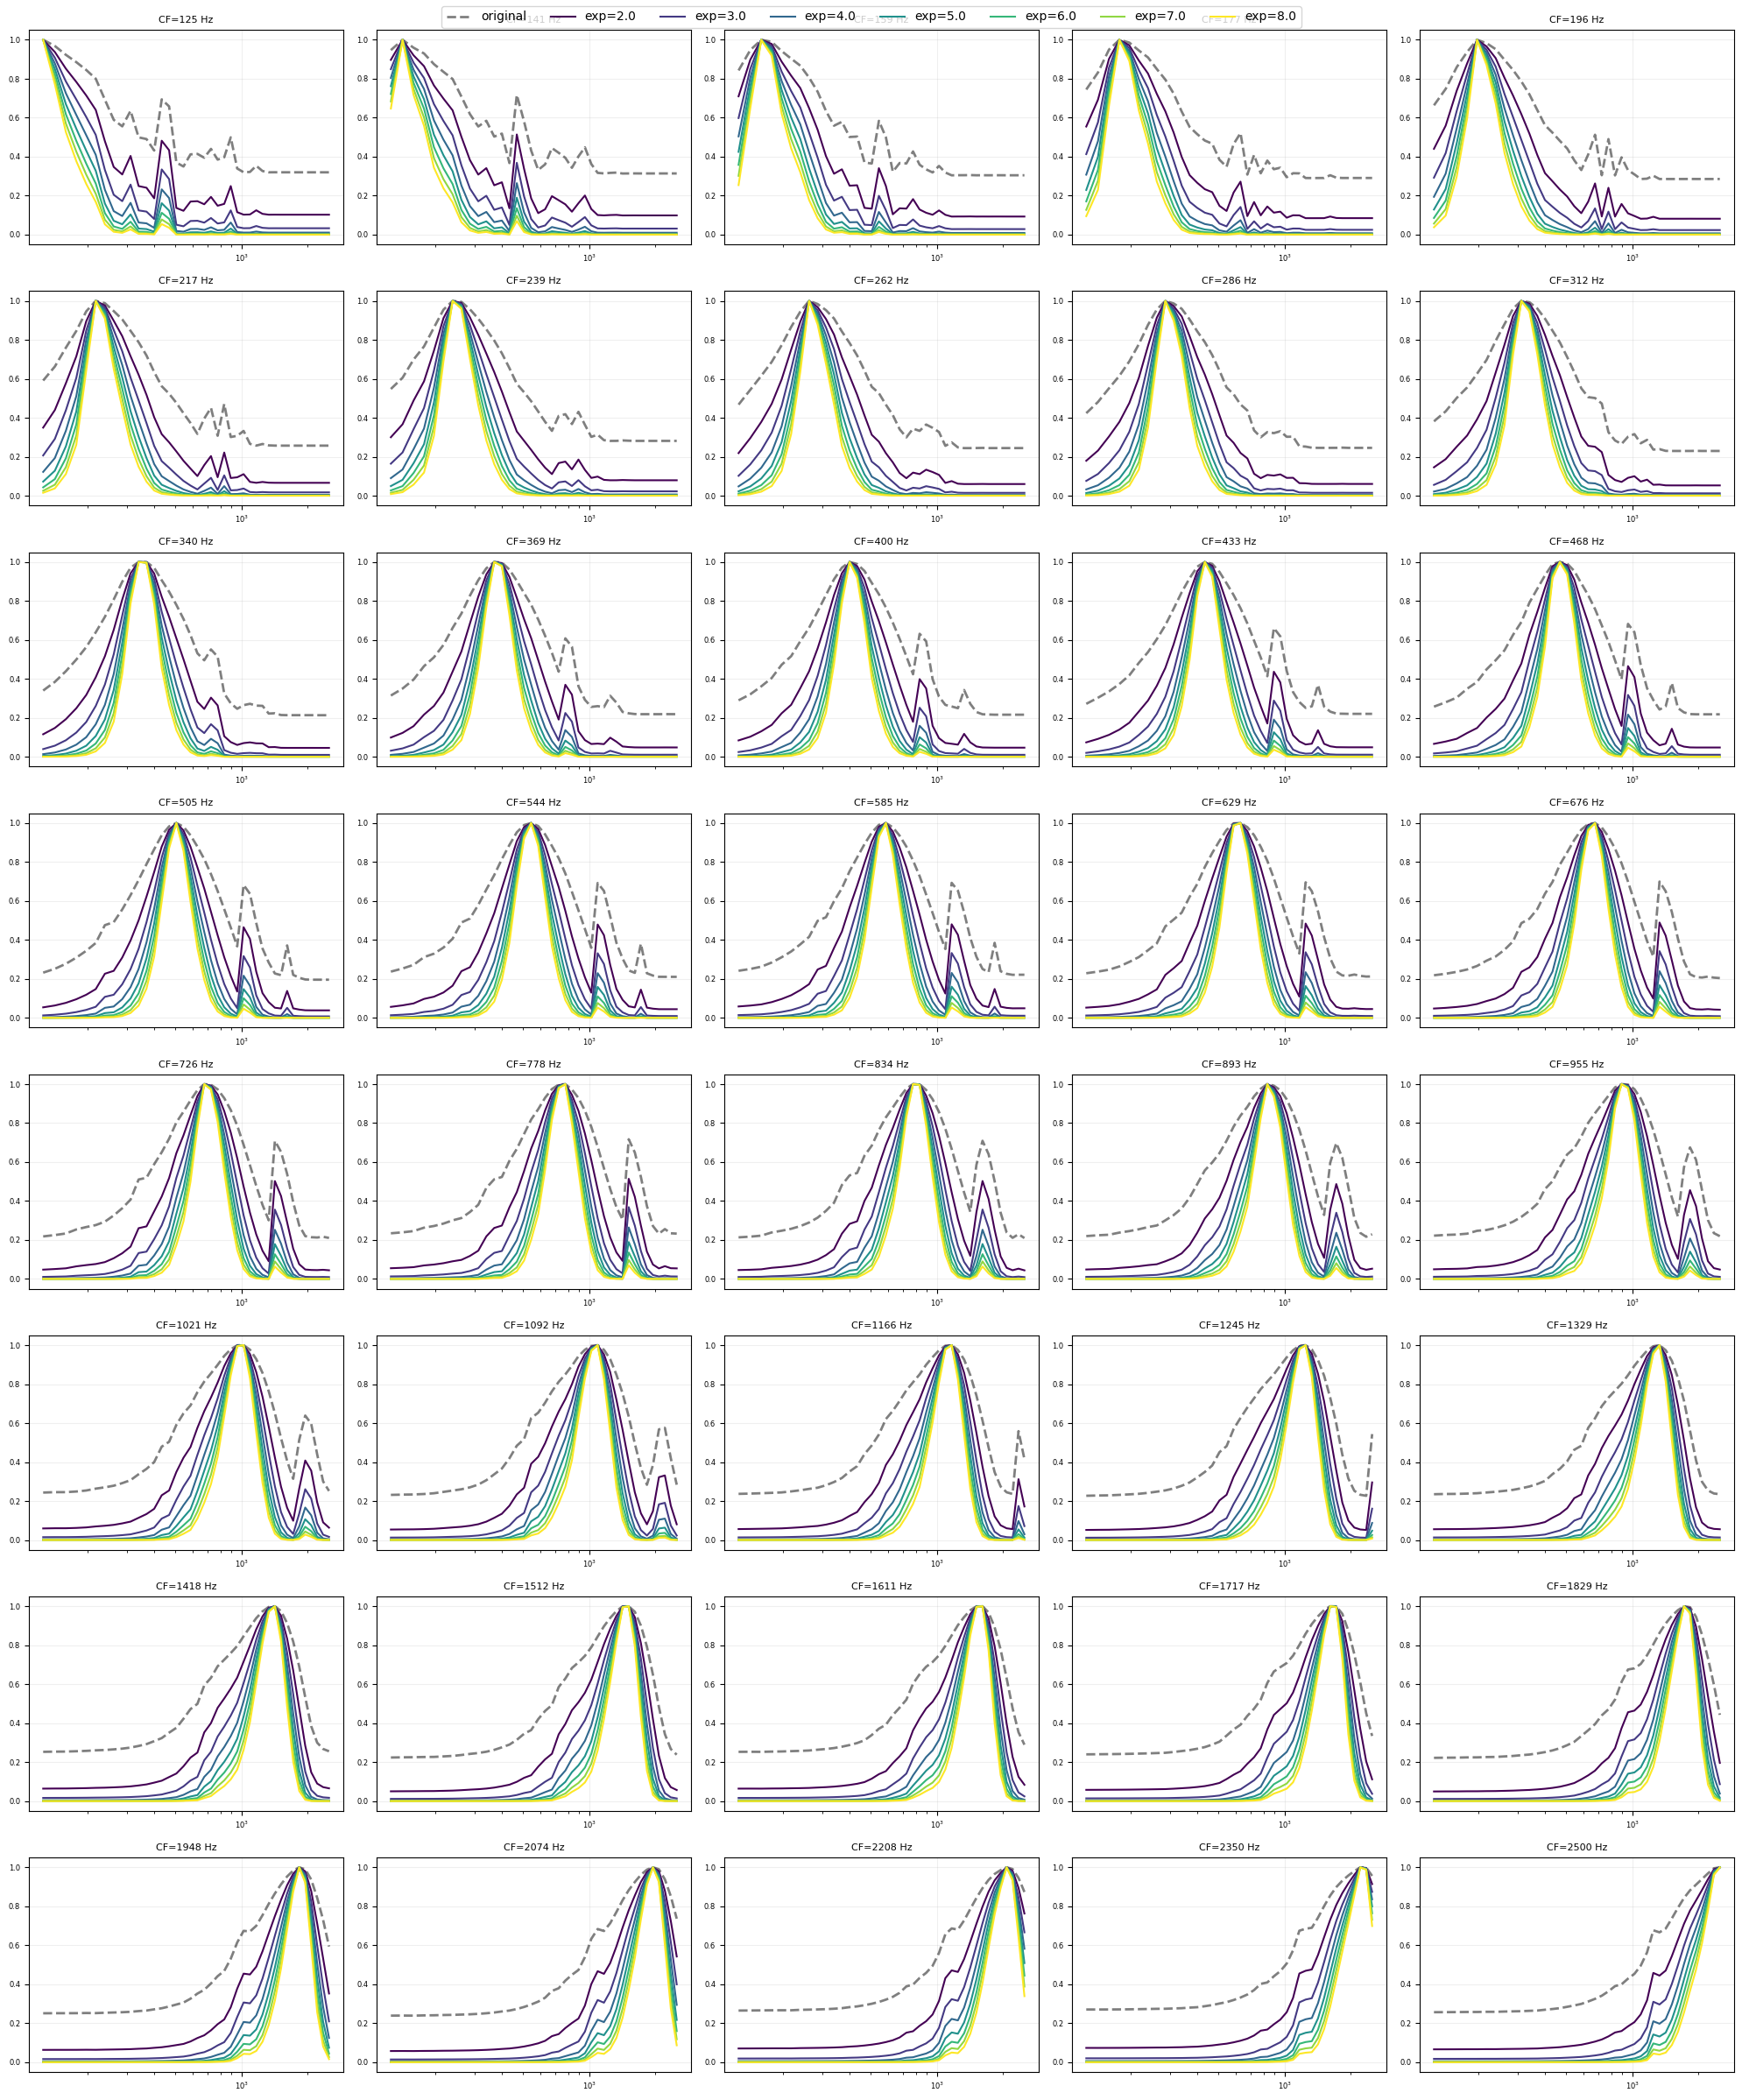

In [ ]:

# Example 3: Plot all CFs with multiple exponents
fig3, axes3 = plot_all_cfs_multiple_exponents(response_matrix, tone_freqs, cf_list, exponents=exponents)
plt.show()



In [ ]:
## Calculate q10dB for DIfferente Exponents
q_results = calculate_q_for_multiple_exponents(
    response_matrix=response_matrix,
    tone_freqs=tone_freqs,
    cf_list=cf_list,
    exponents=exponents,
    power_func=apply_power_with_percf_normalization,
    db_level=-10
)



In [ ]:
# ===== Print Summary =====
print("\n" + "="*60)
print("Q10dB SUMMARY ACROSS CONDITIONS")
print("="*60 + "\n")

summary_df = summarize_q_results(q_results)
print(summary_df.to_string(index=False))




Q10dB SUMMARY ACROSS CONDITIONS

condition   mean_q  median_q    std_q    min_q    max_q  n_valid  n_total
 original 0.563855  0.499714 0.318093 0.052632 1.370689       40       40
      2.0 0.887753  0.759676 0.356991 0.364644 1.874203       40       40
      3.0 1.145821  1.099347 0.396418 0.405844 2.309682       40       40
      4.0 1.611964  1.550190 0.341827 1.159065 2.813731       40       40
      5.0 1.845260  1.803833 0.366025 1.159065 3.194072       40       40
      6.0 2.019543  1.989309 0.358243 1.394547 3.194072       40       40
      7.0 2.300139  2.287403 0.368485 1.627926 3.728005       40       40
      8.0 2.549451  2.512017 0.382899 1.627926 3.728005       40       40


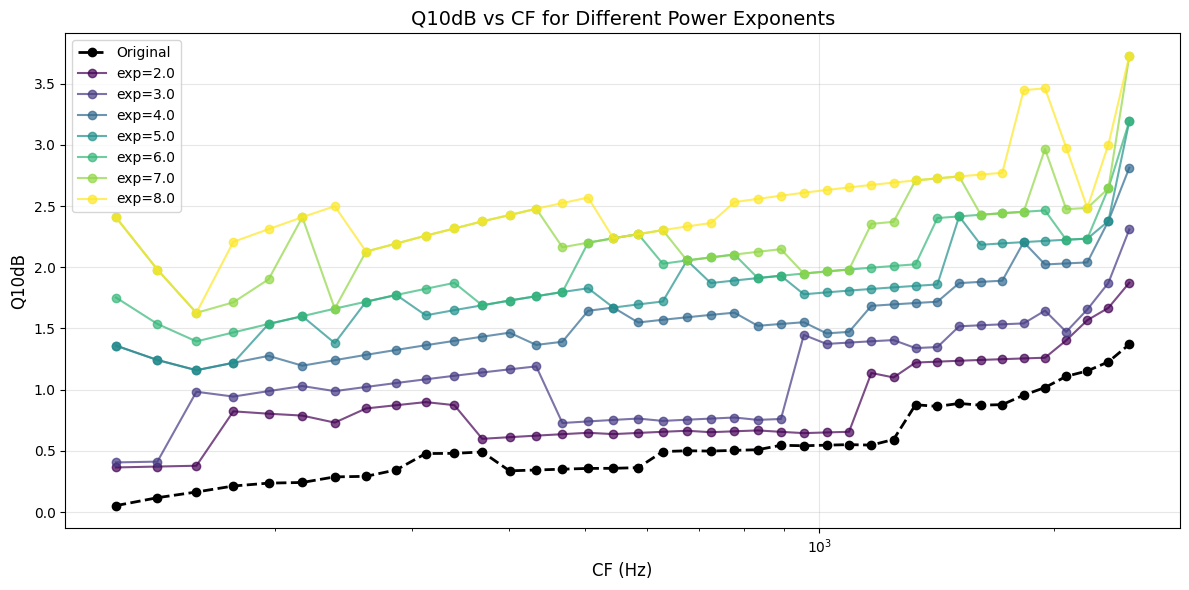

In [ ]:
plt.figure(figsize=(12, 6))

# Plot original
original_q = q_results['original']['q']
plt.plot(cf_list, original_q, 'k--', linewidth=2, label='Original', marker='o')

# Plot each exponent
colors = plt.cm.viridis(np.linspace(0, 1, len(exponents)))
for exp, color in zip(exponents, colors):
    q_vals = q_results[exp]['q']
    plt.plot(cf_list, q_vals, color=color, label=f'exp={exp}', marker='o', alpha=0.7)

plt.xscale('log')
plt.xlabel('CF (Hz)', fontsize=12)
plt.ylabel('Q10dB', fontsize=12)
plt.title('Q10dB vs CF for Different Power Exponents', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:
def plot_q_vs_cf(q_results, cf_list, db_level=-10, figsize=(12, 6)):
    """
    Plot Q factor vs CF for different power exponents.
    
    Parameters:
    -----------
    q_results : dict
        Output from calculate_q_for_multiple_exponents
    cf_list : array
        Characteristic frequencies (Hz)
    db_level : float
        dB level used for Q calculation (for title)
    figsize : tuple
        Figure size
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    import matplotlib.pyplot as plt
    from visualization.plot_cochlea_output import hz_formatter
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot original
    original_q = q_results['original']['q']
    ax.plot(cf_list, original_q, 'k--', linewidth=2, label='Original', marker='o', markersize=6)
    
    # Plot each exponent
    exponents = [k for k in q_results.keys() if k != 'original']
    colors = plt.cm.viridis(np.linspace(0, 1, len(exponents)))
    
    for exp, color in zip(exponents, colors):
        q_vals = q_results[exp]['q']
        ax.plot(cf_list, q_vals, color=color, label=f'exp={exp}', 
                marker='o', alpha=0.7, linewidth=2, markersize=5)
    
    ax.set_xscale('log')
    ax.set_xlabel('CF (Hz)', fontsize=12)
    ax.set_ylabel(f'Q{int(abs(db_level))}dB', fontsize=12)
    ax.set_title(f'Q{int(abs(db_level))}dB vs CF for Different Power Exponents', fontsize=14)
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis with actual Hz values
    ax.xaxis.set_major_formatter(plt.FuncFormatter(hz_formatter))
    
    plt.tight_layout()
    
    return fig, ax



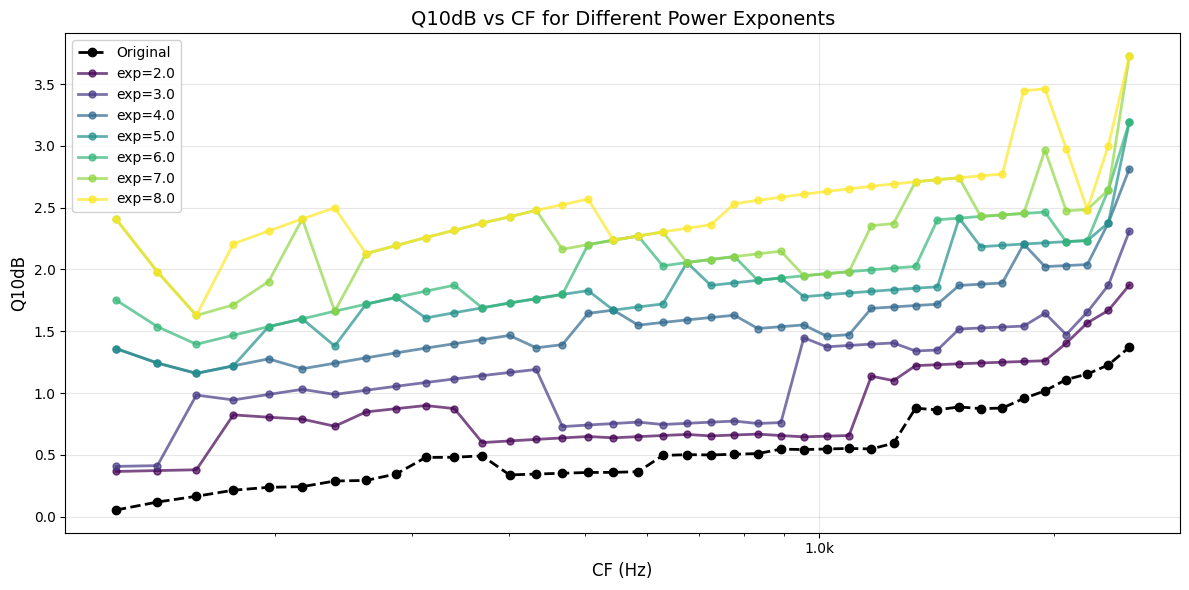

In [ ]:
fig_q, ax_q = plot_q_vs_cf(q_results, cf_list, db_level=-10)
plt.show()



In [ ]:
def plot_q_vs_cf(q_results, cf_list, db_level=-10, figsize=(12, 6)):
    """
    Plot Q factor vs CF for different power exponents.
    
    Parameters:
    -----------
    q_results : dict
        Output from calculate_q_for_multiple_exponents
    cf_list : array
        Characteristic frequencies (Hz)
    db_level : float
        dB level used for Q calculation (for title)
    figsize : tuple
        Figure size
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    import matplotlib.pyplot as plt
    from matplotlib.ticker import ScalarFormatter
    from visualization.plot_cochlea_output import hz_formatter
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot original
    original_q = q_results['original']['q']
    ax.plot(cf_list, original_q, 'k--', linewidth=2, label='Original', marker='o', markersize=6)
    
    # Plot each exponent
    exponents = [k for k in q_results.keys() if k != 'original']
    colors = plt.cm.viridis(np.linspace(0, 1, len(exponents)))
    
    for exp, color in zip(exponents, colors):
        q_vals = q_results[exp]['q']
        ax.plot(cf_list, q_vals, color=color, label=f'exp={exp}', 
                marker='o', alpha=0.7, linewidth=2, markersize=5)
    
    ax.set_xscale('log')
    
    # Set x-axis ticks to CF values
    ax.set_xticks(cf_list)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(hz_formatter))
    
    # Rotate labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    ax.set_xlabel('CF (Hz)', fontsize=12)
    ax.set_ylabel(f'Q{int(abs(db_level))}dB', fontsize=12)
    ax.set_title(f'Q{int(abs(db_level))}dB vs CF for Different Power Exponents', fontsize=14)
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return fig, ax



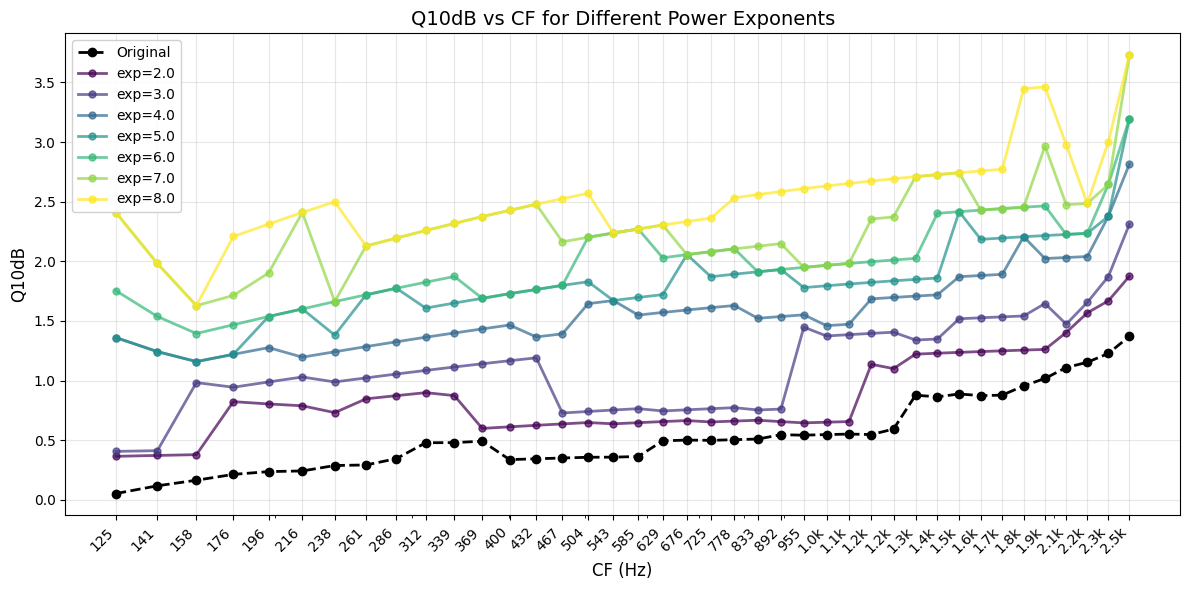

In [ ]:
fig_q, ax_q = plot_q_vs_cf(q_results, cf_list, db_level=-10)
plt.show()



In [ ]:
def plot_bandwidth_vs_cf(q_results, cf_list, db_level=-10, figsize=(12, 6)):
    """
    Plot bandwidth vs CF for different power exponents.
    
    Parameters:
    -----------
    q_results : dict
        Output from calculate_q_for_multiple_exponents
    cf_list : array
        Characteristic frequencies (Hz)
    db_level : float
        dB level used for bandwidth calculation (for title)
    figsize : tuple
        Figure size
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    import matplotlib.pyplot as plt
    from matplotlib.ticker import ScalarFormatter
    from visualization.plot_cochlea_output import hz_formatter
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot original
    original_bw = q_results['original']['bandwidth']
    ax.plot(cf_list, original_bw, 'k--', linewidth=2, label='Original', marker='o', markersize=6)
    
    # Plot each exponent
    exponents = [k for k in q_results.keys() if k != 'original']
    colors = plt.cm.viridis(np.linspace(0, 1, len(exponents)))
    
    for exp, color in zip(exponents, colors):
        bw_vals = q_results[exp]['bandwidth']
        ax.plot(cf_list, bw_vals, color=color, label=f'exp={exp}', 
                marker='o', alpha=0.7, linewidth=2, markersize=5)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Set x-axis ticks to CF values
    ax.set_xticks(cf_list)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(hz_formatter))
    
    # Format y-axis with Hz values
    ax.yaxis.set_major_formatter(plt.FuncFormatter(hz_formatter))
    
    # Rotate x labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    ax.set_xlabel('CF (Hz)', fontsize=12)
    ax.set_ylabel(f'Bandwidth at {int(abs(db_level))}dB (Hz)', fontsize=12)
    ax.set_title(f'Bandwidth vs CF for Different Power Exponents', fontsize=14)
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return fig, ax



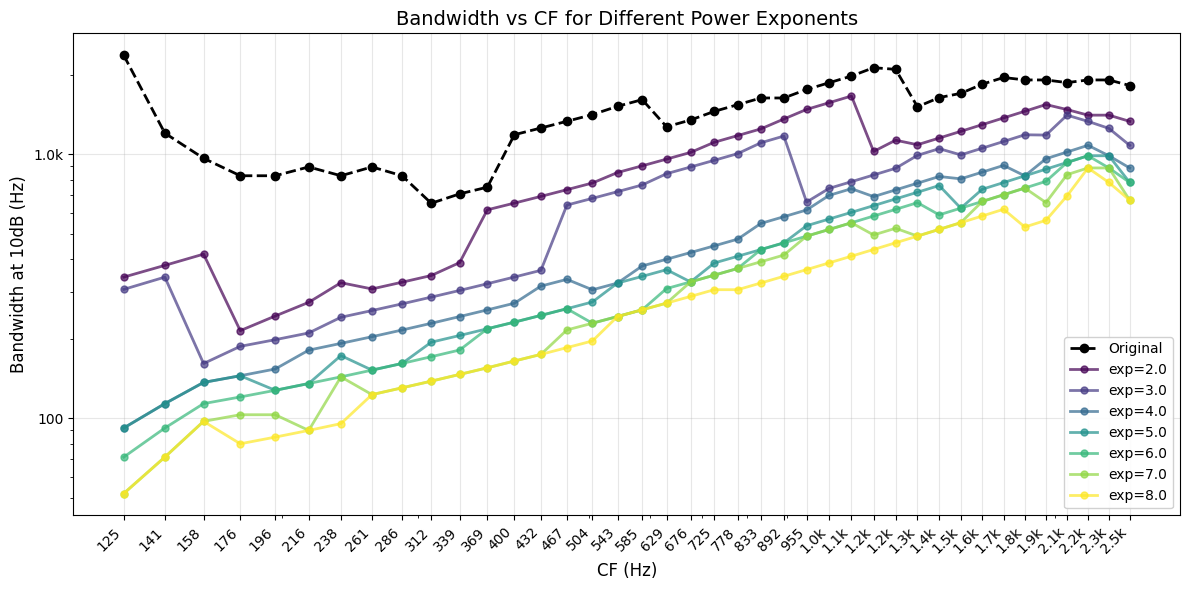

In [ ]:
fig_bw, ax_bw = plot_bandwidth_vs_cf(q_results, cf_list, db_level=-10)
plt.show()

